In [ ]:
hello world

# **Applied AI Assignment: NLP Application (Emotion Recognition)**

# 1. Project Setup and Data Loading
### This initial block handles imports, defines paths, and loads the data.

In [ ]:
# Imports and Data Loading
import pandas as pd
import numpy as np
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Project Setup
print("Setting up project paths")
sns.set_style("whitegrid")
DATA_DIR = "data/"
FIGURES_DIR = "figures/"
GLOVE_FILE = os.path.join(DATA_DIR, 'glove.6B.100d.txt') # Using 100d GloVe

# Create figures directory if it doesn't exist
if not os.path.exists(FIGURES_DIR):
    os.makedirs(FIGURES_DIR)

# Load Emotion Dataset from Hugging Face
print("Loading 'dair-ai/emotion' dataset")
dataset = load_dataset("dair-ai/emotion")
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

# Define Emotion Mapping and Labels
emotion_map = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
emotion_labels = list(emotion_map.values())

print("\nSetup complete. Datasets are loaded.")

--- Setting up project paths and styles ---

--- Loading 'dair-ai/emotion' dataset ---

Setup complete. Datasets are loaded.


# 2. Text Preprocessing
### This section defines the text cleaning pipeline.

In [ ]:
#Text Preprocessing
print("Defining text preprocessing pipeline")
nltk.download('stopwords')
nltk.download('wordnet')
#nltk.download('all')   use this in case other nltk needs to be downloaded
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Cleans and preprocesses text data by:
     Converting to lowercase.
    Removing URLs, mentions, punctuation, and numbers.
    Tokenizing and lemmatizing.
    Removing stopwords.
    """
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@[\w]*', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

# Apply the cleaning function to all data splits
print("Applying cleaning function to train, validation, and test sets...")
train_df['clean_text'] = train_df['text'].apply(clean_text)
val_df['clean_text'] = val_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

print("Preprocessing complete. Example:")
display(train_df[['text', 'clean_text', 'label']].head())

Defining text preprocessing pipeline
Applying cleaning function to train, validation, and test sets...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\seif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\seif\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Preprocessing complete. Example:


,text,clean_text,label
0,i didnt feel humiliated,didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,feeling hopeless damned hopeful around someone...,0
2,im grabbing a minute to post i feel greedy wrong,grabbing minute post feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,ever feeling nostalgic fireplace know still pr...,2
4,i am feeling grouchy,feeling grouchy,3


# 3. Exploratory Data Analysis (EDA)
### Here, we'll visualize the class distribution to understand the class imbalance

--- Analysing class distribution ---


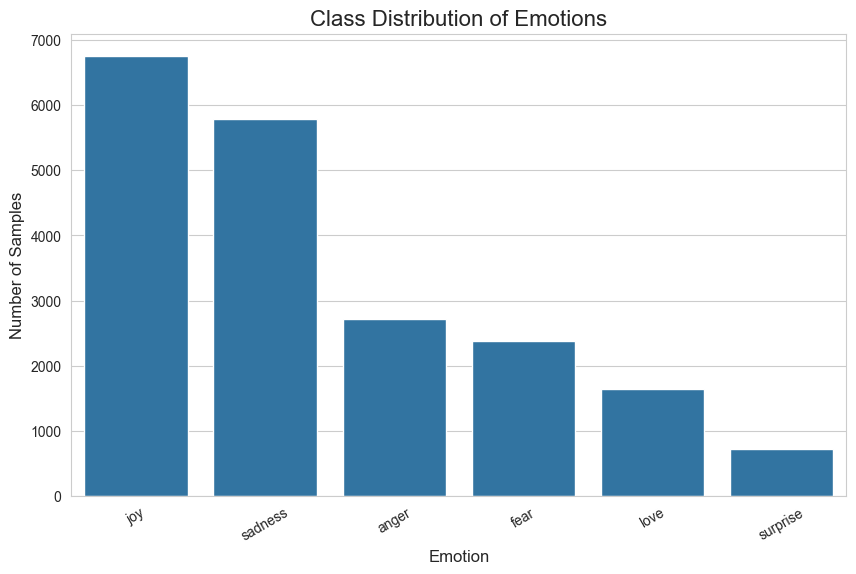


Class Counts:
emotion_name
joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: count, dtype: int64


In [ ]:
# Exploratory Data Analysis
print("Analysing class distribution")

# Combine all splits for a complete overview of the dataset's distribution
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
full_df['emotion_name'] = full_df['label'].map(emotion_map)

plt.figure(figsize=(10, 6))
sns.countplot(data=full_df, x='emotion_name', order=full_df['emotion_name'].value_counts().index)
plt.title("Class Distribution of Emotions", fontsize=16)
plt.ylabel("Number of Samples", fontsize=12)
plt.xlabel("Emotion", fontsize=12)
plt.xticks(rotation=30)
plt.savefig(os.path.join(FIGURES_DIR, 'eda_class_distribution.png'))
plt.show()

print("\nClass Counts:")
print(full_df['emotion_name'].value_counts())

Analysing text length per emotion


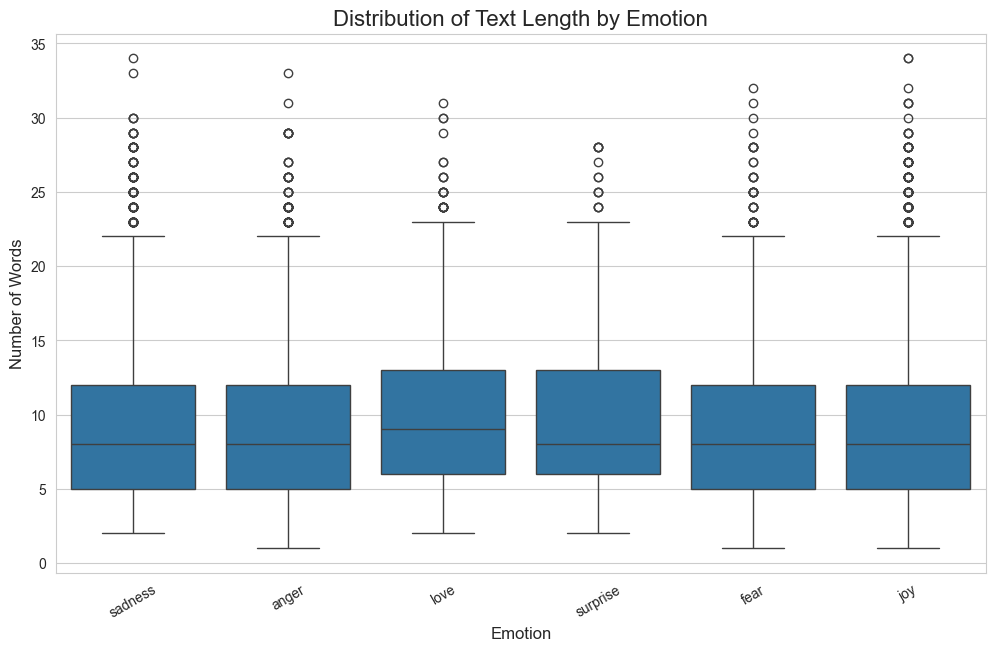

In [ ]:
#Text Length Analysis to see if there is a correlation between emotion and text length
print("Analysing text length per emotion")

# Calculate the length of each clean text
full_df['text_length'] = full_df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 7))
sns.boxplot(x='emotion_name', y='text_length', data=full_df)
plt.title('Distribution of Text Length by Emotion', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Number of Words', fontsize=12)
plt.xticks(rotation=30)
plt.savefig(os.path.join(FIGURES_DIR, 'eda_length_distribution.png'))
plt.show()

# 4. Traditional Machine Learning Models
### In this section, we establish our baseline performance using two classic NLP models. We use TF-IDF to convert text into numerical features.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score

In [ ]:
#Traditional Machine Learning Models
print("Baseline Models: Naive Bayes and Linear SVM")

# Store results for final comparison
results = {}

# Define features (X) and labels (y) for the splits
X_train, y_train = train_df['clean_text'], train_df['label']
X_val, y_val = val_df['clean_text'], val_df['label']
X_test, y_test = test_df['clean_text'], test_df['label']

X_train_full = np.concatenate([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

print("\nCreating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer()

# FIT the vectorizer on the full training text data
tfidf_vectorizer.fit(X_train_full)

# TRANSFORM the train and test
X_train_tfidf = tfidf_vectorizer.transform(X_train_full)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#  train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train_full)
y_pred_nb= nb_model.predict(X_test_tfidf)

print("Naive Bayes Performance:")
print(classification_report(y_test, y_pred_nb, target_names=emotion_labels))

# train Linear SVM
svm_model = LinearSVC(class_weight='balanced')
svm_model.fit(X_train_tfidf, y_train_full)
y_pred_svm= svm_model.predict(X_test_tfidf)

print("Linear SVM Performance:")
print(classification_report(y_test, y_pred_svm, target_names=emotion_labels))

results['Naive Bayes'] = (accuracy_score(y_test, y_pred_nb), f1_score(y_test, y_pred_nb, average='macro'))
results['Linear SVM'] = (accuracy_score(y_test, y_pred_svm), f1_score(y_test, y_pred_svm, average='macro'))


Baseline Models: Naive Bayes and Linear SVM

Creating TF-IDF features...
Naive Bayes Performance:
              precision    recall  f1-score   support

     sadness       0.70      0.93      0.80       581
         joy       0.66      0.99      0.79       695
        love       1.00      0.08      0.14       159
       anger       0.94      0.37      0.53       275
        fear       0.94      0.33      0.48       224
    surprise       0.00      0.00      0.00        66

    accuracy                           0.70      2000
   macro avg       0.71      0.45      0.46      2000
weighted avg       0.75      0.70      0.64      2000



c:\Users\seif\Deep\anaconda3\envs\Computer_Vision\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\seif\Deep\anaconda3\envs\Computer_Vision\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\seif\Deep\anaconda3\envs\Computer_Vision\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Linear SVM Performance:
              precision    recall  f1-score   support

     sadness       0.94      0.92      0.93       581
         joy       0.93      0.91      0.92       695
        love       0.76      0.86      0.81       159
       anger       0.87      0.90      0.89       275
        fear       0.87      0.86      0.86       224
    surprise       0.65      0.73      0.69        66

    accuracy                           0.90      2000
   macro avg       0.84      0.86      0.85      2000
weighted avg       0.90      0.90      0.90      2000



# 5. Deep Learning Preparation
### This part handles all the necessary setup for the deep learning models.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Deep Learning Preparation
print("Preparing Data for Deep Learning Models")

#  Keras Tokenizer
vocab_size = 20000
max_length = 80
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding='post', truncating='post')
X_valid_padded = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding='post', truncating='post')

Preparing Data for Deep Learning Models


In [ ]:
#  GloVe Embedding Matrix
embedding_dim = 100
embeddings_index = {}
try:
    with open(GLOVE_FILE, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
except FileNotFoundError:
    print(f"Error: GloVe file not found at {GLOVE_FILE}. Please download and place it correctly.")

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print("GloVe embedding matrix created.")

#  Class Weights for Deep Learning
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights calculated: {class_weight_dict}")

Preparing Data for Deep Learning Models
GloVe embedding matrix created.
Class weights calculated: {0: 0.5715102157451064, 1: 0.49732686808404825, 2: 2.044989775051125, 3: 1.2351397251814111, 4: 1.3766993632765445, 5: 4.662004662004662}


# 6. BiLSTM

In [ ]:
def build_bilstm_model(num_classes, num_layers, units, dropout, lr, use_glove=True):
    """
    Builds a BiLSTM model with the option to use pre-trained GloVe embeddings.
    """
    model = Sequential()

    if use_glove:
        # Use the pre-trained GloVe embedding matrix
        # The embedding_dim (100) is determined by the GloVe file
        model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=True))
    else:
        # Train an embedding layer from scratch
        # We define embedding dimension as 128
        scratch_embedding_dim = 128
        model.add(Embedding(vocab_size, scratch_embedding_dim, input_length=max_length))

    # Add recurrent layers
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(Bidirectional(LSTM(units, return_sequences=return_sequences)))
        model.add(Dropout(dropout))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
#   Hyperparameter search for BiLSTM
print("Starting Hyperparameter Search for BiLSTM")
num_classes = 6
param_grid = {
    'num_layers': [1, 2],
    'recurrent_units': [32, 64],
    'dropout_rate': [0.3, 0.4],
    'learning_rate': [0.001, 0.0001]
}
best_bilstm_score = -1
best_bilstm_params = {}
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Loop to find the best BiLSTM parameters
for layers in param_grid['num_layers']:
    for units in param_grid['recurrent_units']:
        for dropout in param_grid['dropout_rate']:
            for lr in param_grid['learning_rate']:
                print(f"\nTraining BiLSTM  Layers={layers}, Units={units}, Dropout={dropout}, LR={lr}")
                model = build_bilstm_model(num_classes,layers, units, dropout, lr, use_glove=True)
                model.fit(
                        X_train_padded, y_train,
                        epochs=15, batch_size=64,
                        validation_data=(X_valid_padded, y_val),
                        class_weight=class_weight_dict,
                        callbacks=[early_stopping],
                        verbose=0
                    )
                y_pred_val = np.argmax(model.predict(X_valid_padded), axis=1)
                score = f1_score(y_val, y_pred_val, average='macro')
                print(f"--> Validation Macro F1-Score: {score:.4f}")
                if score > best_bilstm_score:
                    best_bilstm_score = score
                    best_bilstm_params = {'num_layers': layers, 'units': units, 'dropout': dropout, 'lr': lr}

print("\n BiLSTM Hyperparameter Search Complete")
print(f"Best Validation Score for BiLSTM: {best_bilstm_score:.4f}")
print(f"Best BiLSTM Parameters: {best_bilstm_params}")



Starting Hyperparameter Search for BiLSTM

Training BiLSTM  Layers=1, Units=32, Dropout=0.3, LR=0.001
63/63 [==============================] - 2s 13ms/step
--> Validation Macro F1-Score: 0.8815

Training BiLSTM  Layers=1, Units=32, Dropout=0.3, LR=0.0001
63/63 [==============================] - 2s 12ms/step
--> Validation Macro F1-Score: 0.8075

Training BiLSTM  Layers=1, Units=32, Dropout=0.4, LR=0.001
63/63 [==============================] - 2s 12ms/step
--> Validation Macro F1-Score: 0.8796

Training BiLSTM  Layers=1, Units=32, Dropout=0.4, LR=0.0001
63/63 [==============================] - 2s 20ms/step
--> Validation Macro F1-Score: 0.7347

Training BiLSTM  Layers=1, Units=64, Dropout=0.3, LR=0.001
63/63 [==============================] - 4s 39ms/step
--> Validation Macro F1-Score: 0.8716

Training BiLSTM  Layers=1, Units=64, Dropout=0.3, LR=0.0001
63/63 [==============================] - 3s 37ms/step
--> Validation Macro F1-Score: 0.8253

Training BiLSTM  Layers=1, Units=64, Dropo

In [ ]:
# RUN THIS TO USE THE BEST PARAMETERS IN CASE THE KERNEL RESETS TO NOT DO THE SEARCH AGAIN
#best_bilstm_params = {'num_layers': 2, 'units': 64, 'dropout': 0.4, 'lr': 0.001}

In [ ]:
# Combine original train and validation sets for final training
# Will be used on the BiLSTM and CNN models after parameter search
X_train_full = np.concatenate([X_train_padded, X_valid_padded])
y_train_full = np.concatenate([y_train, y_val])

# Calculate class weights for the full training data
class_weights_full = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_full), y=y_train_full)
class_weight_dict_full = dict(enumerate(class_weights_full))

In [ ]:
# Train BiLSTM model with GloVe
print("\n Training BiLSTM (GloVe) Model on Full Training Data")

# Build the final model using the function
bilstm_glove_model = build_bilstm_model(
    num_classes,
    best_bilstm_params['num_layers'],
    best_bilstm_params['units'],
    best_bilstm_params['dropout'],
    best_bilstm_params['lr']
)

# Train on the combined dataset
bilstm_glove_model.fit(
    X_train_full, y_train_full,
    epochs=5,
    batch_size=64,
    class_weight=class_weight_dict_full,
    verbose=1
)



 Training BiLSTM (GloVe) Model on Full Training Data
Epoch 1/5
282/282 [==============================] - 126s 394ms/step - loss: 1.2657 - accuracy: 0.4606
Epoch 2/5
282/282 [==============================] - 133s 473ms/step - loss: 0.4028 - accuracy: 0.8523
Epoch 3/5
282/282 [==============================] - 128s 453ms/step - loss: 0.2249 - accuracy: 0.9169
Epoch 4/5
282/282 [==============================] - 130s 460ms/step - loss: 0.1584 - accuracy: 0.9386
Epoch 5/5
282/282 [==============================] - 130s 461ms/step - loss: 0.1226 - accuracy: 0.9505


In [ ]:
# Evaluation of the  BiLSTM
y_pred_bilstm_glove = np.argmax(bilstm_glove_model.predict(X_test_padded), axis=1)
results['BiLSTM (GloVe)'] = (accuracy_score(y_test, y_pred_bilstm_glove), f1_score(y_test, y_pred_bilstm_glove, average='macro'))

print("Performance of BiLSTM (GloVe) on Test Set")
print(classification_report(y_test, y_pred_bilstm_glove, target_names=emotion_labels))

bilstm_glove_model.save('Models/bilstm_glove_model.keras')
print("BiLSTM model trained and saved as 'bilstm_glove_model.keras'")

63/63 [==============================] - 7s 92ms/step
Performance of BiLSTM (GloVe) on Test Set
              precision    recall  f1-score   support

     sadness       0.99      0.93      0.96       581
         joy       0.97      0.88      0.93       695
        love       0.70      0.97      0.81       159
       anger       0.90      0.95      0.92       275
        fear       0.86      0.91      0.88       224
    surprise       0.69      0.83      0.75        66

    accuracy                           0.91      2000
   macro avg       0.85      0.91      0.88      2000
weighted avg       0.92      0.91      0.92      2000

BiLSTM model trained and saved as 'bilstm_glove_model.keras'


In [ ]:
# Train BiLSTM model from scratch
print("Training BiLSTM Model on Full Training Data from scratch:")


# Build the  model using the function
bilstm_scratch_model = build_bilstm_model(
    num_classes,
    best_bilstm_params['num_layers'],
    best_bilstm_params['units'],
    best_bilstm_params['dropout'],
    best_bilstm_params['lr'],
    use_glove=False
)

# Train
bilstm_scratch_model.fit(
    X_train_full, y_train_full,
    epochs=5,
    batch_size=64,
    class_weight=class_weight_dict_full,
    verbose=1
)

Training BiLSTM Model on Full Training Data from scratch:
Epoch 1/5
282/282 [==============================] - 332s 1s/step - loss: 1.2930 - accuracy: 0.4519
Epoch 2/5
282/282 [==============================] - 394s 1s/step - loss: 0.3159 - accuracy: 0.8941
Epoch 3/5
282/282 [==============================] - 417s 1s/step - loss: 0.1508 - accuracy: 0.9468
Epoch 4/5
282/282 [==============================] - 364s 1s/step - loss: 0.0948 - accuracy: 0.9664
Epoch 5/5
282/282 [==============================] - 354s 1s/step - loss: 0.0910 - accuracy: 0.9707


In [ ]:
# Evaluation of BiLSTM (Scratch)
y_pred_bilstm_scratch = np.argmax(bilstm_scratch_model.predict(X_test_padded), axis=1)
results['BiLSTM (Scratch)'] = (accuracy_score(y_test, y_pred_bilstm_scratch), f1_score(y_test, y_pred_bilstm_scratch, average='macro'))

print("Performance of BiLSTM (Scratch) on Test Set")
print(classification_report(y_test, y_pred_bilstm_scratch, target_names=emotion_labels))
bilstm_scratch_model.save('Models/bilstm_scratch_model.keras')
print("BiLSTM model trained and saved as 'bilstm_scratch_model.keras'")

63/63 [==============================] - 13s 170ms/step
Performance of BiLSTM (Scratch) on Test Set
              precision    recall  f1-score   support

     sadness       0.96      0.92      0.94       581
         joy       0.96      0.89      0.92       695
        love       0.69      0.95      0.80       159
       anger       0.86      0.93      0.90       275
        fear       0.90      0.79      0.84       224
    surprise       0.65      0.89      0.75        66

    accuracy                           0.90      2000
   macro avg       0.84      0.90      0.86      2000
weighted avg       0.91      0.90      0.90      2000

BiLSTM model trained and saved as 'bilstm_scratch_model.keras'


# 7. 1D-CNN

In [ ]:
from tensorflow.keras.layers import  Conv1D, GlobalMaxPooling1D

In [ ]:
def build_cnn_model(num_classes,filters, kernel_size, dropout, lr, use_glove=True):
    """
    Builds a 1D-CNN model with the option to use pre-trained GloVe embeddings.
    """
    model = Sequential()

    if use_glove:
        # Using the pre-trained GloVe embedding matrix. The dimension is 100.
        model.add(Embedding(
            vocab_size,
            100,  # Must match the GloVe file dimension
            weights=[embedding_matrix],
            input_length=max_length,
            trainable=True
        ))
    else:
        scratch_embedding_dim = 128
        model.add(Embedding(
            vocab_size,
            scratch_embedding_dim,
            input_length=max_length
        ))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(dropout))
    model.add(Dense(filters // 2, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
print("Starting Hyperparameter Search for 1D-CNN")

# Define the search space for the 1D-CNN model
cnn_param_grid = {
    'filters': [64, 128],
    'kernel_size': [3, 5],
    'dropout_rate': [0.3, 0.5],
    'learning_rate': [0.001, 0.0001]
}
num_classes = 6
best_cnn_score = -1
best_cnn_params = {}
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Loop through all CNN parameters
for filters in cnn_param_grid['filters']:
    for kernel_size in cnn_param_grid['kernel_size']:
        for dropout in cnn_param_grid['dropout_rate']:
            for lr in cnn_param_grid['learning_rate']:

                print(f"\nTraining 1D-CNN | Filters={filters}, Kernel Size={kernel_size}, Dropout={dropout}, LR={lr}")

                cnn = build_cnn_model(num_classes,filters, kernel_size, dropout, lr)

                cnn.fit(
                    X_train_padded, y_train,
                    epochs=15,
                    batch_size=64,
                    validation_data=(X_valid_padded, y_val),
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping],
                    verbose=0
                )

                # Evaluate on validation set to find best params
                y_pred_val = np.argmax(cnn.predict(X_valid_padded), axis=1)
                score = f1_score(y_val, y_pred_val, average='macro')

                print(f"--> Validation Macro F1-Score: {score:.4f}")

                if score > best_cnn_score:
                    best_cnn_score = score
                    best_cnn_params = {'filters': filters, 'kernel_size': kernel_size, 'dropout': dropout, 'lr': lr}

print("CNN Hyperparameter Search Complete")
print(f"Best Validation Score for 1D-CNN: {best_cnn_score:.4f}")
print(f"Best CNN Parameters: {best_cnn_params}")


Starting Hyperparameter Search for 1D-CNN

Training 1D-CNN | Filters=64, Kernel Size=3, Dropout=0.3, LR=0.001
63/63 [==============================] - 0s 3ms/step
--> Validation Macro F1-Score: 0.8960

Training 1D-CNN | Filters=64, Kernel Size=3, Dropout=0.3, LR=0.0001
63/63 [==============================] - 0s 2ms/step
--> Validation Macro F1-Score: 0.8302

Training 1D-CNN | Filters=64, Kernel Size=3, Dropout=0.5, LR=0.001
63/63 [==============================] - 0s 2ms/step
--> Validation Macro F1-Score: 0.8955

Training 1D-CNN | Filters=64, Kernel Size=3, Dropout=0.5, LR=0.0001
63/63 [==============================] - 0s 3ms/step
--> Validation Macro F1-Score: 0.7724

Training 1D-CNN | Filters=64, Kernel Size=5, Dropout=0.3, LR=0.001
63/63 [==============================] - 0s 3ms/step
--> Validation Macro F1-Score: 0.8907

Training 1D-CNN | Filters=64, Kernel Size=5, Dropout=0.3, LR=0.0001
63/63 [==============================] - 0s 3ms/step
--> Validation Macro F1-Score: 0.8221



In [ ]:
# RUN THIS TO USE THE BEST PARAMETERS IN CASE THE KERNEL RESETS TO NOT DO THE SEARCH AGAIN
#best_cnn_params = {'filters': 128, 'kernel_size': 3, 'dropout': 0.5, 'lr': 0.001}

In [ ]:
# Train CNN model with GloVe with best parameters and save it
print("Training 1D-CNN (GloVe) Model on Full Training Data")


cnn_glove_model = build_cnn_model(
    num_classes,
    best_cnn_params['filters'],
    best_cnn_params['kernel_size'],
    best_cnn_params['dropout'],
    best_cnn_params['lr']
)

cnn_glove_model.fit(
    X_train_full, y_train_full,
    epochs=5,
    batch_size=64,
    class_weight=class_weight_dict_full,
    verbose=1
)



Training Final Best 1D-CNN Model on Full Training Data
Epoch 1/5
282/282 [==============================] - 16s 53ms/step - loss: 1.5115 - accuracy: 0.3549
Epoch 2/5
282/282 [==============================] - 15s 52ms/step - loss: 0.5950 - accuracy: 0.7749
Epoch 3/5
282/282 [==============================] - 15s 52ms/step - loss: 0.3212 - accuracy: 0.8862
Epoch 4/5
282/282 [==============================] - 15s 54ms/step - loss: 0.2368 - accuracy: 0.9118
Epoch 5/5
282/282 [==============================] - 15s 52ms/step - loss: 0.1928 - accuracy: 0.9281


In [ ]:
y_pred_cnn_glove = np.argmax(cnn_glove_model.predict(X_test_padded), axis=1)

results['1D-CNN (Glove)'] = (accuracy_score(y_test, y_pred_cnn_glove), f1_score(y_test, y_pred_cnn_glove, average='macro'))
print("Performance of CNN (GloVe) on Test Set")
print(classification_report(y_test, y_pred_cnn_glove, target_names=emotion_labels))

cnn_glove_model.save('Models/cnn_glove_model.keras')
print("\n1D-CNN model trained and saved as 'cnn_glove_model.keras'")

63/63 [==============================] - 0s 5ms/step
Performance of CNN (GloVe) on Test Set
              precision    recall  f1-score   support

     sadness       0.98      0.92      0.95       581
         joy       0.98      0.88      0.93       695
        love       0.70      0.96      0.81       159
       anger       0.91      0.93      0.92       275
        fear       0.90      0.89      0.89       224
    surprise       0.61      0.95      0.74        66

    accuracy                           0.91      2000
   macro avg       0.85      0.92      0.87      2000
weighted avg       0.93      0.91      0.91      2000


1D-CNN model trained and saved as 'cnn_glove_model.keras'


In [ ]:
# Train CNN model from scratch with best parameters and save it
print("Training  1D-CNN Model (Scratch) on Full Training Data")

cnn_scratch_model = build_cnn_model(
    num_classes,
    best_cnn_params['filters'],
    best_cnn_params['kernel_size'],
    best_cnn_params['dropout'],
    best_cnn_params['lr'],
    use_glove=False
)

cnn_scratch_model.fit(
    X_train_full, y_train_full,
    epochs=5,
    batch_size=64,
    class_weight=class_weight_dict_full,
    verbose=1
)



Training  1D-CNN Model on Full Training Data
Epoch 1/5
282/282 [==============================] - 19s 65ms/step - loss: 1.1177 - accuracy: 0.5581
Epoch 2/5
282/282 [==============================] - 18s 64ms/step - loss: 0.2237 - accuracy: 0.9211
Epoch 3/5
282/282 [==============================] - 18s 65ms/step - loss: 0.1438 - accuracy: 0.9456
Epoch 4/5
282/282 [==============================] - 18s 65ms/step - loss: 0.0997 - accuracy: 0.9623
Epoch 5/5
282/282 [==============================] - 19s 66ms/step - loss: 0.0754 - accuracy: 0.9725


In [ ]:
y_pred_cnn_scratch = np.argmax(cnn_scratch_model.predict(X_test_padded), axis=1)
results['1D-CNN (Scratch)'] = (accuracy_score(y_test, y_pred_cnn_scratch), f1_score(y_test, y_pred_cnn_scratch, average='macro'))

print("Performance of CNN (Scratch) on Test Set")
print(classification_report(y_test, y_pred_cnn_scratch, target_names=emotion_labels))

cnn_scratch_model.save('Models/cnn_scratch_model.keras')
print("1D-CNN model trained and saved as 'cnn_scratch_model.keras'")

63/63 [==============================] - 0s 5ms/step
Performance of CNN (Scratch) on Test Set
              precision    recall  f1-score   support

     sadness       0.97      0.92      0.95       581
         joy       0.97      0.89      0.93       695
        love       0.73      0.91      0.81       159
       anger       0.89      0.95      0.92       275
        fear       0.87      0.88      0.87       224
    surprise       0.66      0.92      0.77        66

    accuracy                           0.91      2000
   macro avg       0.85      0.91      0.88      2000
weighted avg       0.92      0.91      0.91      2000

1D-CNN model trained and saved as 'cnn_scratch_model.keras'


Final Summary of All Model Performances


,Model,Accuracy,Macro F1-Score
0,BiLSTM (GloVe),0.9125,0.876237
1,1D-CNN (Scratch),0.9105,0.876162
2,1D-CNN (Glove),0.9110,0.874407
3,BiLSTM (Scratch),0.8965,0.858198
4,Linear SVM,0.8950,0.849261
5,Naive Bayes,0.7045,0.456867


Visualisation 1: Performance Comparison Bar Plot 


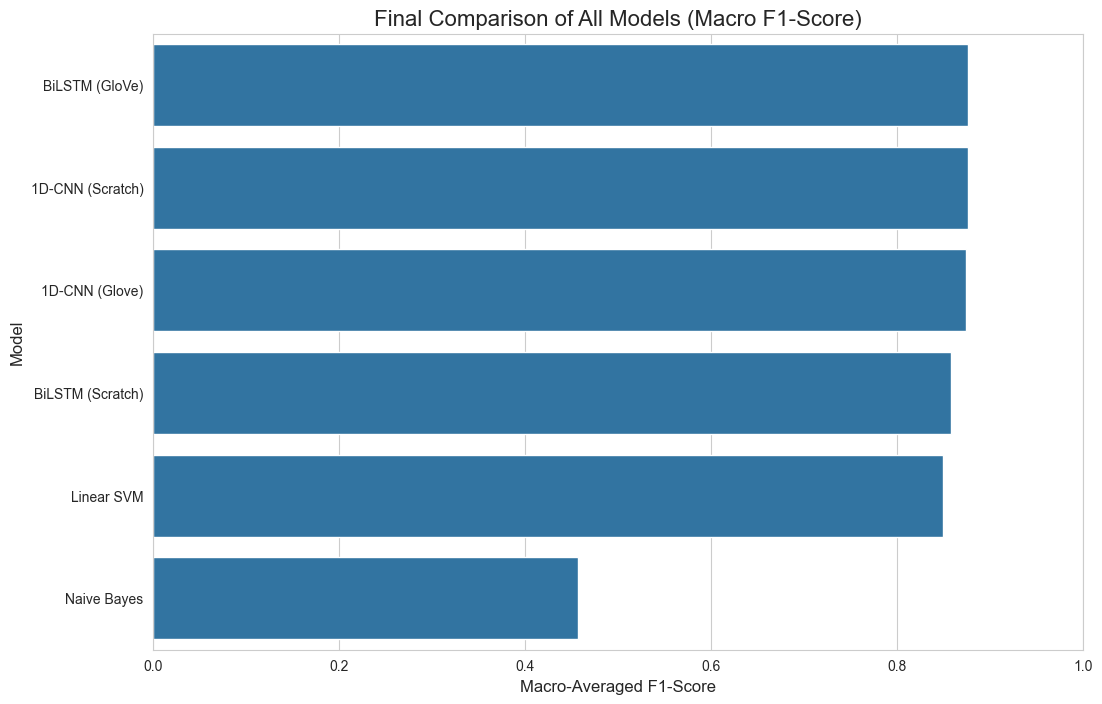

Visualisation 2: Confusion Matrix for Best Model: BiLSTM (GloVe)


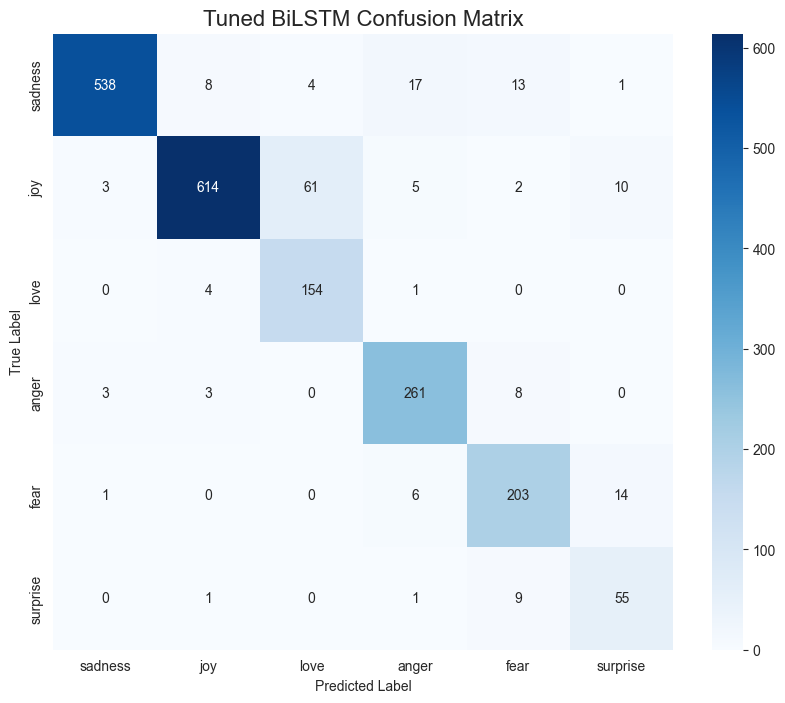

In [ ]:
print("Final Summary of All Model Performances")

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy', 'Macro F1-Score'])
results_df = results_df.sort_values(by='Macro F1-Score', ascending=False).reset_index().rename(columns={'index': 'Model'})

display(results_df)

print("Visualisation 1: Performance Comparison Bar Plot ")
plt.figure(figsize=(12, 8))
sns.barplot(x='Macro F1-Score', y='Model', data=results_df, orient='h')
plt.title('Final Comparison of All Models (Macro F1-Score)', fontsize=16)
plt.xlabel('Macro-Averaged F1-Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0, 1.0)
plt.savefig(os.path.join(FIGURES_DIR, 'final_model_comparison.png'))
plt.show()


print("Visualisation 2: Confusion Matrix for Best Model: BiLSTM (GloVe)")

cm = confusion_matrix(y_test, y_pred_bilstm_glove)
cm_df = pd.DataFrame(cm, index=emotion_labels, columns=emotion_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Tuned BiLSTM Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(FIGURES_DIR, 'confusion_matrix_best_model.png'))
plt.show()